In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

import statsmodels.tsa.api as smt

import pandas as pd
import numpy as np
import scipy

In [3]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = ''  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_CallSpread
ES_PutSpread
ES_ContFut
ZS_BullishCollarBW
ZS_BearishCollarBW
ZS_CallSpread
ZS_PutSpread
ZS_ContFut
CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
ZW_BullishCollarBW
ZW_BearishCollarBW
ZW_CallSpread
ZW_PutSpread
ZW_ContFut
ZN_BullishCollarBW
ZN_BearishCollarBW
ZN_CallSpread
ZN_PutSpread
ZN_ContFut
NG_BullishCollarBW
NG_BearishCollarBW
NG_CallSpread
NG_PutSpread
NG_ContFut
ZC_BullishCollarBW
ZC_BearishCollarBW
ZC_CallSpread
ZC_PutSpread
ZC_ContFut
CL_SMART_Ichimoku_Long
ES_SMART_Ichimoku_Long
NG_SMART_Ichimoku_Long
ZC_SMART_Ichimoku_Long
ZS_SMART_Ichimoku_Long
ZW_SMART_Ichimoku_Long
ZN_SMART_Ichimoku_Long
CL_SMART_Ichimoku_VerticalSpread_Bullish
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged_test
CL_SmartEXO_Ichi_Bearish_Straddle_BullCall_Spread_0Delta_EXP
CL_SmartEXO_Ichi__BullCall_Spread_Delta_150_EXP
CL_

In [4]:
class Strategy_RollingHurstExp(StrategyBase):
    name = 'Strategy_RollingHurstExp'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    

    def calc_entryexit_rules(self, hurst_window, hurst_value, hurst_median_window, rules_index):
        def hurst(ts):
            """Returns the Hurst Exponent of the time series vector ts"""
            # Create the range of lag values
            lags = range(2, 20)
            # Calculate the array of the variances of the lagged differences
            tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
            # Use a linear fit to estimate the Hurst Exponent
            poly = polyfit(log(lags), log(tau), 1)
            # Return the Hurst exponent from the polyfit output
            return poly[0]*2.0
    
        i = 1
        px_ser = self.data.exo
        
        #print(px_ser.size)
        rolling_hurst = px_ser.dropna().rolling(hurst_window).apply(lambda x: hurst(x))
        
        if rules_index == 0:
            entry_rule = (rolling_hurst <= hurst_value)

            exit_rule = (rolling_hurst < rolling_hurst.rolling(hurst_median_window).median())
            return entry_rule, exit_rule
        
        if rules_index == 1:
            entry_rule = (rolling_hurst >= hurst_value)

            exit_rule = (rolling_hurst > rolling_hurst.rolling(hurst_median_window).median())
            return entry_rule, exit_rule
        
        if rules_index == 2:
            entry_rule = (rolling_hurst <= hurst_value)

            exit_rule = (rolling_hurst > rolling_hurst.rolling(hurst_median_window).median())
            return entry_rule, exit_rule
        
        if rules_index == 3:
            entry_rule = (rolling_hurst >= hurst_value)

            exit_rule = (rolling_hurst < rolling_hurst.rolling(hurst_median_window).median())
            return entry_rule, exit_rule
    
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, hurst_window, hurst_value, hurst_median_window, rules_index = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, hurst_window, hurst_value, hurst_median_window, rules_index = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule, exit_rule = self.calc_entryexit_rules(hurst_window, hurst_value, hurst_median_window, rules_index)

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Script settings

In [229]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': Strategy_RollingHurstExp,
        'exo_name': 'NG_SmartEXO_Ichi_Put_Spread_150Delta_Bi',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        #OptParam('Pct rank value', 9, 0, 1, 0.2),
                        OptParam('Roll. Hurst window', 2, 30, 60, 5),
                        OptParam('Hurst value', 0, 0.51, 0.91, 0.11),
                        OptParam('Hurst median window', 2, 25, 25, 10),
                        OptParamArray('Rules index', np.arange(1)),
                        
            ],
    },
    'swarm': {
        'members_count': 1,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [230]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

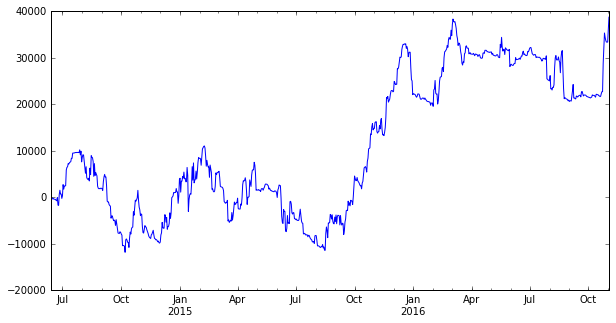

In [231]:
smgr.strategy.data.exo.plot()

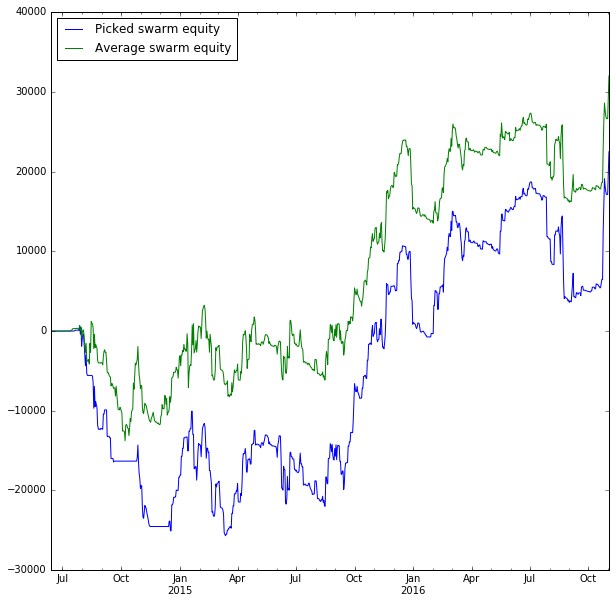

In [232]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

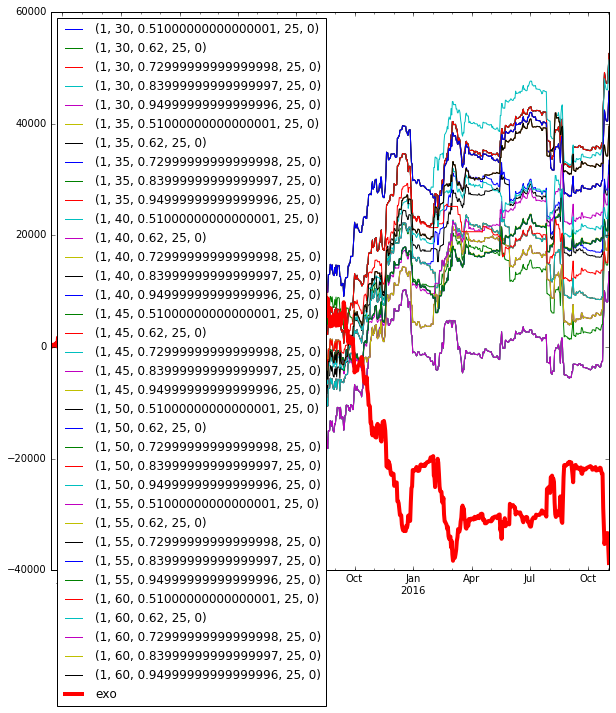

In [233]:
smgr.raw_swarm.plot(legend=True)
(smgr.strategy.data.exo*-1).plot(linewidth=4, color='red')
legend(loc=2);

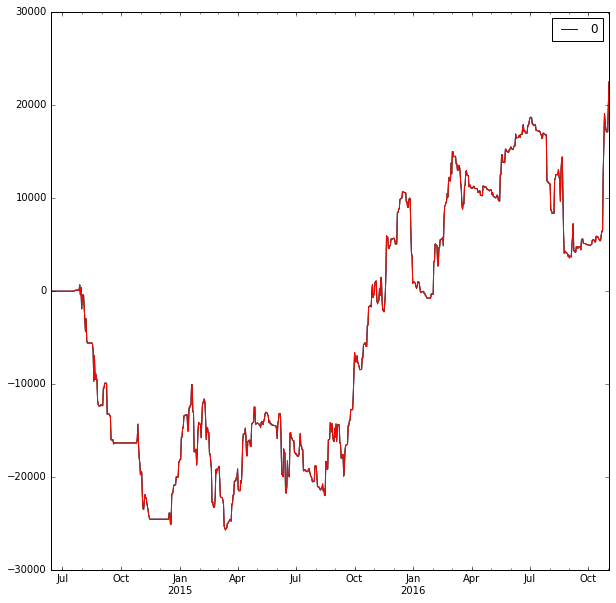

In [234]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

# Swarm exposure

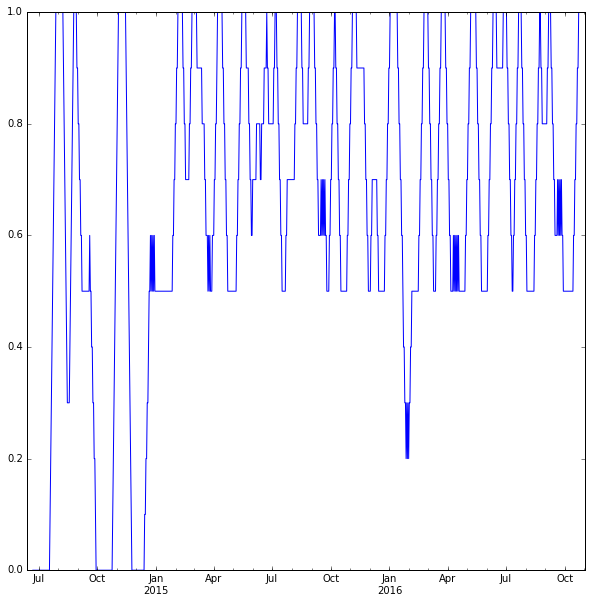

In [235]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [236]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [237]:
smgr.strategy.exoinfo.exo_info

{'dbdata': {'_id': ObjectId('581a83ab20bb1d0dfe64c8a3'),
  'calc_date': datetime.datetime(2016, 11, 2, 17, 36, 29, 83000),
  'name': 'NG_SmartEXO_Ichi_Put_Spread_150Delta_Bi',
  'position': {'_realized_pnl': 33358.56163321559,
   'positions': {'211625458': {'leg_name': 'bearish',
     'qty': 6.0,
     'value': 12371.494381441255},
    '211644987': {'leg_name': '', 'qty': -6.0, 'value': -3026.7905608741708}}},
  'series': b'\x80\x03cpandas.core.frame\nDataFrame\nq\x00)\x81q\x01}q\x02(X\x04\x00\x00\x00_typq\x03X\t\x00\x00\x00dataframeq\x04X\x05\x00\x00\x00_dataq\x05cpandas.core.internals\nBlockManager\nq\x06)\x81q\x07(]q\x08(cpandas.indexes.base\n_new_Index\nq\tcpandas.indexes.base\nIndex\nq\n}q\x0b(X\x04\x00\x00\x00dataq\x0ccnumpy.core.multiarray\n_reconstruct\nq\rcnumpy\nndarray\nq\x0eK\x00\x85q\x0fC\x01bq\x10\x87q\x11Rq\x12(K\x01K\x02\x85q\x13cnumpy\ndtype\nq\x14X\x02\x00\x00\x00O8q\x15K\x00K\x01\x87q\x16Rq\x17(K\x03X\x01\x00\x00\x00|q\x18NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK?tq\x19b

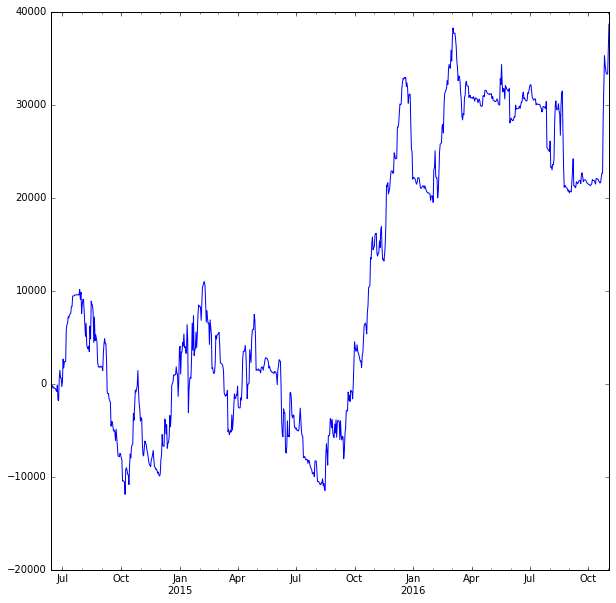

In [238]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

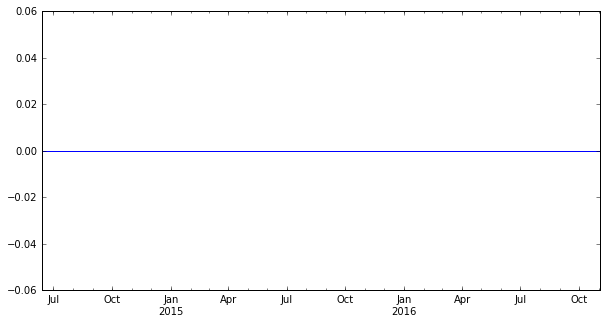

In [239]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

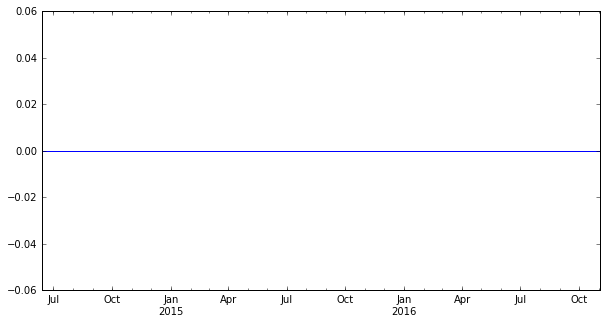

In [240]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [241]:
smgr.save('./swarms/')

In [242]:
smgr.raw_swarm#.plot()

,"(1, 30, 0.51000000000000001, 25, 0)","(1, 30, 0.62, 25, 0)","(1, 30, 0.72999999999999998, 25, 0)","(1, 30, 0.83999999999999997, 25, 0)","(1, 30, 0.94999999999999996, 25, 0)","(1, 35, 0.51000000000000001, 25, 0)","(1, 35, 0.62, 25, 0)","(1, 35, 0.72999999999999998, 25, 0)","(1, 35, 0.83999999999999997, 25, 0)","(1, 35, 0.94999999999999996, 25, 0)",...,"(1, 55, 0.51000000000000001, 25, 0)","(1, 55, 0.62, 25, 0)","(1, 55, 0.72999999999999998, 25, 0)","(1, 55, 0.83999999999999997, 25, 0)","(1, 55, 0.94999999999999996, 25, 0)","(1, 60, 0.51000000000000001, 25, 0)","(1, 60, 0.62, 25, 0)","(1, 60, 0.72999999999999998, 25, 0)","(1, 60, 0.83999999999999997, 25, 0)","(1, 60, 0.94999999999999996, 25, 0)"
2014-06-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
